In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 0 # manualy take the first GPU

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 0


In [3]:
import numpy
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10 # we can use also cifar100
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import tensorflow as tf
import time
from IPython.display import SVG

Using TensorFlow backend.


In [4]:
# LOAD DATA
num_classes = 10
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
#CNN:VGG-like convnet
def model(lr, weightdecay, dropout):
  # create model
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout==True:model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout==True:model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  if dropout==True:model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  # Optimizer
  sgd = optimizers.SGD(lr, decay=weightdecay, momentum=0.9, nesterov=True)
  # Compile model
  #loss : 'categorical_crossentropy', 'mean_squared_error'
  #optimizer : 'adam', 'sgd(lr)',adadelta, adagrad, 'rmsprop(lr=0.001, decay=0.0)'', Adamax, Nadam
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  return model

In [6]:
# pré-TRAINING
batch_size = 32
epochs = 50
# build the models
modelA = model(lr=0.01, weightdecay=0, dropout=False)
modelB = model(lr=0.01, weightdecay=1e-6, dropout=True)

In [7]:
# Save the models and the initial weights
modelA.save("models/modelA.h5")
modelB.save("models/modelB.h5")
modelA.save_weights("models/modelA_weights_epoch0.h5")
modelB.save_weights("models/modelB_weights_epoch0.h5")

In [8]:
# get initial weights
weights_epoch0_modelA = modelA.get_weights()
weights_epoch0_modelB = modelB.get_weights()

### Training model A

In [9]:
historyListA = []
weights_list_modelA = []
nombre_de_coucheA = len(modelA.get_weights())
cosinus_distance_list_modelA = numpy.zeros((nombre_de_coucheA,epochs))
test_list_modelA = []
for i in range(epochs):
    tmps1=time.clock()
    historyListA.append(modelA.fit(x_train,y_train, batch_size=batch_size,
                          epochs=1, validation_data=(x_test, y_test),
                          shuffle=True, verbose=0))
    # get weights
    weights_list_modelA.append(modelA.get_weights())
    # get cosinus distance pour chaque couche et chaque epoch
    for j in range(nombre_de_coucheA):
        cosinus_distance_list_modelA[j][i] = scipy.spatial.distance.cosine(numpy.array(weights_epoch0_modelA[j]).flatten(), numpy.array(weights_list_modelA[i][j]).flatten())                          
    tmps2=time.clock()
    print('>>epochs:',i,"  >> Temps d'execution = %d sec" %(tmps2-tmps1))

/linux/mnovak/Documents/Thesis/Code/myenv/lib/python3.5/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


>>epochs: 0   >> Temps d'execution = 13 sec
>>epochs: 1   >> Temps d'execution = 12 sec
>>epochs: 2   >> Temps d'execution = 12 sec
>>epochs: 3   >> Temps d'execution = 12 sec
>>epochs: 4   >> Temps d'execution = 12 sec
>>epochs: 5   >> Temps d'execution = 12 sec
>>epochs: 6   >> Temps d'execution = 12 sec
>>epochs: 7   >> Temps d'execution = 12 sec
>>epochs: 8   >> Temps d'execution = 12 sec
>>epochs: 9   >> Temps d'execution = 12 sec
>>epochs: 10   >> Temps d'execution = 12 sec
>>epochs: 11   >> Temps d'execution = 12 sec
>>epochs: 12   >> Temps d'execution = 12 sec
>>epochs: 13   >> Temps d'execution = 13 sec
>>epochs: 14   >> Temps d'execution = 12 sec
>>epochs: 15   >> Temps d'execution = 12 sec
>>epochs: 16   >> Temps d'execution = 12 sec
>>epochs: 17   >> Temps d'execution = 12 sec
>>epochs: 18   >> Temps d'execution = 12 sec
>>epochs: 19   >> Temps d'execution = 12 sec
>>epochs: 20   >> Temps d'execution = 12 sec
>>epochs: 21   >> Temps d'execution = 12 sec
>>epochs: 22   >> Te

In [10]:
historyA_acc = []
historyA_val_acc = []
historyA_loss = []
historyA_val_loss = []
for i in range(epochs):
    historyA_acc.append(historyListA[i].history['acc'])
    historyA_val_acc.append(historyListA[i].history['val_acc'])
    historyA_loss.append(historyListA[i].history['loss'])
    historyA_val_loss.append(historyListA[i].history['val_loss'])

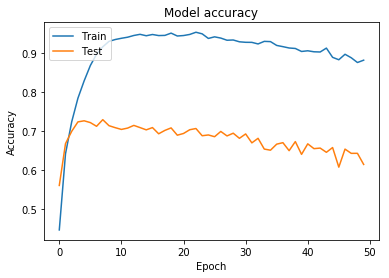

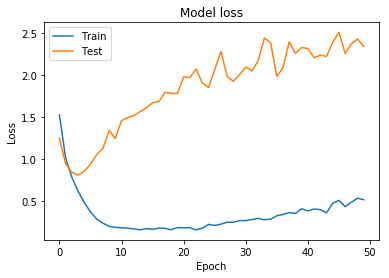

In [11]:
# Plot training & validation accuracy values
plt.plot(historyA_acc)
plt.plot(historyA_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyA_loss)
plt.plot(historyA_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

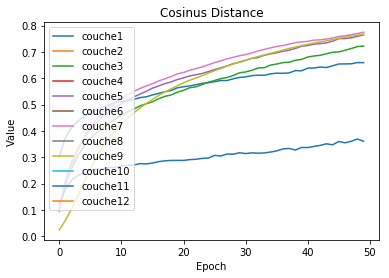

In [12]:
# Plot cosinus distance
#print(cosinus_distance_list_modelA)
cosinus_distance_modelA = numpy.zeros((nombre_de_coucheA,epochs))
for j in range(nombre_de_coucheA):
    for i in range(epochs):
        cosinus_distance_modelA[j][i] = cosinus_distance_list_modelA[j][i]

for j in range(nombre_de_coucheA):      
    plt.plot(cosinus_distance_modelA[j])
plt.title('Cosinus Distance')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['couche1','couche2','couche3','couche4','couche5','couche6','couche7','couche8','couche9','couche10','couche11','couche12'], loc='upper left')
plt.show()

In [13]:
modelA.save_weights("models/modelA_weights_epoch50.h5")

### Training model B

In [14]:
historyListB = []
weights_list_modelB = []
nombre_de_coucheB = len(modelB.get_weights())
cosinus_distance_list_modelB = numpy.zeros((nombre_de_coucheB,epochs))
for i in range(epochs):
    tmps1=time.clock()
    historyListB.append(modelB.fit(x_train,y_train, batch_size=batch_size,
                          epochs=1, validation_data=(x_test, y_test),
                          shuffle=True, verbose=0))
    # get weights
    weights_list_modelB.append(modelB.get_weights())
    # get cosinus distance pour chaque couche et chaque epoch
    for j in range(nombre_de_coucheB):
        cosinus_distance_list_modelB[j][i] = scipy.spatial.distance.cosine(numpy.array(weights_epoch0_modelB[j]).flatten(), numpy.array(weights_list_modelB[i][j]).flatten())                          
    tmps2=time.clock()
    print('>>epochs:',i,"  >> Temps d'execution = %d sec" %(tmps2-tmps1))

>>epochs: 0   >> Temps d'execution = 14 sec
>>epochs: 1   >> Temps d'execution = 13 sec
>>epochs: 2   >> Temps d'execution = 13 sec
>>epochs: 3   >> Temps d'execution = 14 sec
>>epochs: 4   >> Temps d'execution = 13 sec
>>epochs: 5   >> Temps d'execution = 13 sec
>>epochs: 6   >> Temps d'execution = 14 sec
>>epochs: 7   >> Temps d'execution = 13 sec
>>epochs: 8   >> Temps d'execution = 14 sec
>>epochs: 9   >> Temps d'execution = 13 sec
>>epochs: 10   >> Temps d'execution = 13 sec
>>epochs: 11   >> Temps d'execution = 13 sec
>>epochs: 12   >> Temps d'execution = 13 sec
>>epochs: 13   >> Temps d'execution = 13 sec
>>epochs: 14   >> Temps d'execution = 13 sec
>>epochs: 15   >> Temps d'execution = 13 sec
>>epochs: 16   >> Temps d'execution = 13 sec
>>epochs: 17   >> Temps d'execution = 13 sec
>>epochs: 18   >> Temps d'execution = 13 sec
>>epochs: 19   >> Temps d'execution = 13 sec
>>epochs: 20   >> Temps d'execution = 14 sec
>>epochs: 21   >> Temps d'execution = 13 sec
>>epochs: 22   >> Te

In [15]:
historyB_acc = []
historyB_val_acc = []
historyB_loss = []
historyB_val_loss = []
for i in range(epochs):
    historyB_acc.append(historyListB[i].history['acc'])
    historyB_val_acc.append(historyListB[i].history['val_acc'])
    historyB_loss.append(historyListB[i].history['loss'])
    historyB_val_loss.append(historyListB[i].history['val_loss'])

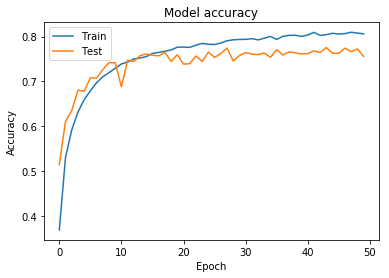

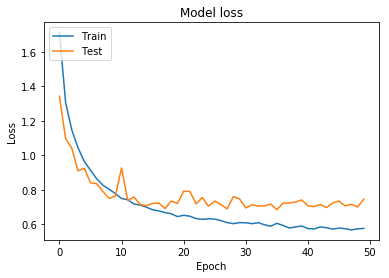

In [16]:
# Plot training & validation accuracy values
plt.plot(historyB_acc)
plt.plot(historyB_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyB_loss)
plt.plot(historyB_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

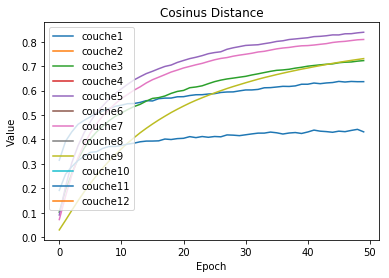

In [17]:
# Plot cosinus distance
#print(cosinus_distance_list_modelB)
cosinus_distance_modelB = numpy.zeros((nombre_de_coucheB,epochs))
for j in range(nombre_de_coucheB):
    for i in range(epochs):
        cosinus_distance_modelB[j][i] = cosinus_distance_list_modelB[j][i]

for j in range(nombre_de_coucheB):      
    plt.plot(cosinus_distance_modelB[j])
plt.title('Cosinus Distance')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['couche1','couche2','couche3','couche4','couche5','couche6','couche7','couche8','couche9','couche10','couche11','couche12'], loc='upper left')
plt.show()

In [18]:
modelB.save_weights("models/modelB_weights_epoch50.h5")

In [19]:
# EVALUATION
# Final evaluation of the models
scoresA = modelA.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresA[0])
print('Test accuracy:', scoresA[1])
print("Model 0 Error: %.2f%%" % (100-scoresA[1]*100))
scoresB = modelB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresB[0])
print('Test accuracy:', scoresB[1])
print("Model 0 Error: %.2f%%" % (100-scoresB[1]*100))

10000/10000 [==============================] - 1s 70us/step
Test loss: 2.3422891954422
Test accuracy: 0.6146
Model 0 Error: 38.54%
10000/10000 [==============================] - 1s 72us/step
Test loss: 0.7456463940620423
Test accuracy: 0.7555
Model 0 Error: 24.45%


Le modele A n'utilise pas dropout et weightsdecay, alors que le modele B oui. Ce dernier devrait donc en principe mieux généraliser.